# Classification of local minimums and maximums

The objective of this notebook is to perform classification on the data factored in `feature_creation.ipynb`. As local minimum or maximum are known a posteriori we want to employ CNN to infer a prediction.

The date range is from `2020-04-01` to `2023-12-31` as it contains trends both upwards and downwards for the stock `DAL` quoted on the Milan Stock Exchange.

The column `feature` of our dataframe can assume values:
- `max` if the price is a local maximum
- `min` if the price is a local minimum
- `def` otherwise


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, LeakyReLU, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from pyts.image import MarkovTransitionField

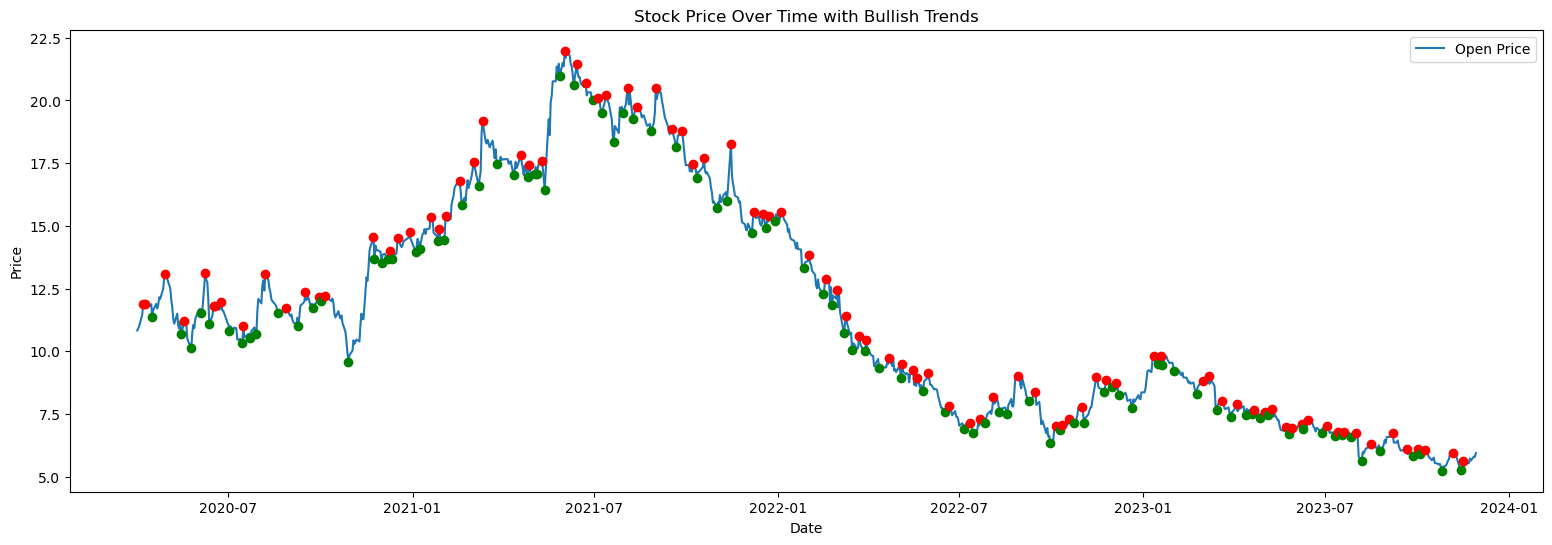

In [13]:
start = "2020-04-01"
end = "2023-12-31"
df = pd.read_csv('data/DAL.MI_f.csv', index_col=0, parse_dates=True)

plt.figure(figsize=(19, 6))
plt.plot(df['Open'], label='Open Price')
for index in range(0, df.shape[0]):
    el = df['feature'].iloc[index]
    if (el == 'max'):
        plt.plot(df.index[index], df['Open'].iloc[index], 'ro')
    if (el == 'min'):
        plt.plot(df.index[index], df['Open'].iloc[index], 'go')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Over Time with Bullish Trends')
plt.legend()
plt.show()

As the single price would not mean much without context the objective will be to
gather together a sequence of trading days to predict if the current day is a minimum a maximum or nothing.

In [14]:
n_features = 3
n_timesteps = 10
train_size = int(len(data) * 0.80)

data = np.array(df.drop('feature', axis=1).values)

feature_mapping = {'min': 0, 'def': 1, 'max': 2}
inverted_mapping = {value: key for key, value in feature_mapping.items()}
target = np.array(df['feature'].map(feature_mapping).values)

def create_markov_transition_field_sequences(data, target, n_timesteps):
    mtf = MarkovTransitionField(image_size=n_timesteps)
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        sequence = data[i:i+n_timesteps]
        mtf_image = mtf.fit_transform(sequence.reshape(1, -1))
        X.append(mtf_image[0])
        y.append(target[i+n_timesteps-1])
    return np.array(X), np.array(y)

data_seq_mtf, target_seq_mtf = create_markov_transition_field_sequences(data, target, n_timesteps)

x_train_mtf, x_test_mtf = np.array(data_seq_mtf[:train_size]), np.array(data_seq_mtf[train_size:])
y_train_mtf, y_test_mtf = np.array(target_seq_mtf[:train_size]), np.array(target_seq_mtf[train_size:])

y_train_mtf_encoded = np.eye(n_features)[y_train_mtf]
y_test_mtf_encoded = np.eye(n_features)[y_test_mtf]


def build_model_2d(input_shape, l2_value):
    kernel_size = (3, 3)
    pool_size = (2, 2)
    l2_ = l2(l2_value)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(64, kernel_size, activation='relu', kernel_regularizer=l2_, bias_regularizer=l2_))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(30, activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2_, bias_regularizer=l2_))
    model.add(Dense(n_features, activation='softmax'))
    return model

In [23]:
target

array([1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 2, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 0, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1,

In [22]:
class_weights = compute_class_weight('balanced', classes=np.unique(target), y=target)
class_weight_dict = dict(enumerate(class_weights))
print(f'dicts: {class_weight_dict}')

dicts: {0: 3.432234432234432, 1: 0.41423519009725907, 2: 3.3949275362318843}


In [17]:
batch_size = 1000
epochs = 1000
patience = 10
l2_value = 0

input_shape_mtf = (n_timesteps, n_timesteps, 1)

model_mtf = build_model_2d(input_shape_mtf, l2_value)

model_mtf.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy', Precision(), Recall()])

history_mtf = model_mtf.fit(x_train_mtf, y_train_mtf_encoded,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_split=0.2,
                            # class_weight=class_weight_dict,
                            callbacks=[EarlyStopping(
                                monitor='val_loss',
                                patience=patience,
                                verbose=2,
                                mode='min',
                                restore_best_weights=True,
                            )])

Epoch 1/1000
1/1 [==============================] - 1s 574ms/step - loss: 1.1044 - accuracy: 0.0985 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.0837 - val_accuracy: 0.8200 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.0844 - accuracy: 0.8047 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.0690 - val_accuracy: 0.8200 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/1000
1/1 [==============================] - 0s 26ms/step - loss: 1.0709 - accuracy: 0.8047 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.0570 - val_accuracy: 0.8200 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/1000
1/1 [==============================] - 0s 30ms/step - loss: 1.0597 - accuracy: 0.8047 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.0467 - val_accuracy: 0.8200 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/100

In [20]:
y_pred_mtf = model_mtf.predict(x_train_mtf)
y_pred_classes_mtf = np.argmax(y_pred_mtf, axis=1)
y_true_mtf = np.argmax(y_train_mtf_encoded, axis=1) 

conf_matrix_mtf = confusion_matrix(y_true_mtf, y_pred_classes_mtf)
accuracy_mtf = accuracy_score(y_true_mtf, y_pred_classes_mtf)
report_mtf = classification_report(y_true_mtf, y_pred_classes_mtf)

print("MTF Model Accuracy:", accuracy_mtf)
print("MTF Model Confusion Matrix:\n", conf_matrix_mtf)
print("MTF Model Classification Report:\n", report_mtf)


24/24 [==============================] - 0s 939us/step
MTF Model Accuracy: 0.807743658210948
MTF Model Confusion Matrix:
 [[  0  74   0]
 [  0 605   0]
 [  0  70   0]]
MTF Model Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        74
           1       0.81      1.00      0.89       605
           2       0.00      0.00      0.00        70

    accuracy                           0.81       749
   macro avg       0.27      0.33      0.30       749
weighted avg       0.65      0.81      0.72       749



/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrea/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
